# Supervised Learning 

The goal of this notebook is to complement the chapter on supervised learning from the book Statistics for Epilepsy

In [1]:
%pip install seaborn==0.11.2
%pip install pandas==1.1.5
%pip install sklearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Supervised Learning with Applications to Seizure Detection and Classification

In the following section we illustrate how several supervised learning algorithms can be used for the seizure detection and seizure classification. Please note that this is just a part of what is required to build a full seizure detection system and on its own is not sufficient to produce a fully function seizure detection system. Typically, interest lies in first identifying a seizure from an EEG signal and then classifying the seizure signal into one of many types of seizures. 

In [1]:
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split

##### Load Seizure Detection and Classification Data

In order to load the dataset change the directory to where the data resides. The data is available for download on the books github repo.

Load in the data represented as 

**X_detect, X_classify** - **feature data** matrix of shape sliding_window_eeg_time_series x (#channels * 24 signal frequencies)

**y_detect, y_classify** - **labels**
    
    1. Detection - 1 for seizure signal; 0 for non-seizure signal
    2. Classification - label with one of the following classes: 'ABSZ', 'CPSZ', 'FNSZ', 'GNSZ', 'SPSZ', 'TCSZ', 'TNSZ'

**patient_id_detect, patient_id_classify** - patient_id used for aggreagting the predictions from sliding_window_eeg_time_series (rows in X matrix) to patient level predictions

In [2]:
path_detect = 'C:/Users/evankov/epilepsy_book/sl_chapter/tuh_eeg_seizure/preprocessed_ml_data/v1.4.0/ml_data/seizure_detection_from_non_seizure/'
path_classify = 'C:/Users/evankov/epilepsy_book/sl_chapter/tuh_eeg_seizure/preprocessed_ml_data/v1.4.0/ml_data/seizure_classification/data_sample_frac_0_15/'

In [3]:
# Seizure Detection
X_detect = pickle.load(open(path_detect + 'X.pkl', 'rb'))
y_detect = pickle.load(open(path_detect + 'y.pkl', 'rb'))
patient_id_detect = pickle.load(open(path_detect + 'patient_id.pkl', 'rb'))

# Seizure Classification
X_classify = pickle.load(open(path_classify + 'X.pkl', 'rb'))
y_classify = pickle.load(open(path_classify + 'y.pkl', 'rb'))
patient_id_classify = pickle.load(open(path_classify + 'patient_id.pkl', 'rb'))
label_names = ['ABSZ', 'CPSZ', 'FNSZ', 'GNSZ', 'MYSZ', 'SPSZ', 'TCSZ', 'TNSZ']

In [4]:
print(X_detect.shape)
print(X_classify.shape)

(46398, 480)
(44596, 480)


#### Prepare the data for seizure detection

The original data is split into training, validation and test datasets. The training dataset is used for fitting the models to the data. The validation data is used for hyperparameter optimization and the test data is used for reporting the final model performance on data that the model has not seen during training or validation. Since the datasets avalilable are large ~ 45K observations for detection and classification- we perform a single train, validation, test split, with ratio ~ 50%-20%-30%, respectively, rather than k-fold cross validation. The split is done via the built-in sklearn function *train_test_split*. We set the random_state to a fixed value for reproducibility of our results.

In [5]:
train_size = 0.7

# Detection
X_detect, X_detect_test, y_detect, y_detect_test, patient_id_detect, patient_id_detect_test = train_test_split(X_detect, y_detect, patient_id_detect, random_state=42, train_size = train_size)
X_detect_train, X_detect_val, y_detect_train, y_detect_val, patient_id_detect_train, patient_id_detect_val = train_test_split(X_detect, y_detect, patient_id_detect, random_state=42, train_size = train_size)

# Classification
X_classify, X_classify_test, y_classify, y_classify_test, patient_id_classify, patient_id_classify_test = train_test_split(X_classify, y_classify, patient_id_classify, random_state=42, train_size = train_size)
X_classify_train, X_classify_val, y_classify_train, y_classify_val, patient_id_classify_train, patient_id_classify_val = train_test_split(X_classify, y_classify, patient_id_classify, random_state=42, train_size = train_size)

Before applying any supervised learning algorithm, it is important to explore the data. A particular issue, quie prevalent in practice, is class imbalance. It refers to a situation where one (some) of the classes present in the training data heavily dominate the other class(es). The loss function being optimized assigns the same weight to each sample by default. If we consider an example with 99% of the examples being from one class, and we treat each sample equally, then the output of the model can achieve low values the negative log loss by setting the coefficients $\theta$ so that the samples are predicted to be the majority class. This can in turn decrease the ability to correctly identify the minority class, and yet still have overall good performance. This is not desirable epsecially in situations when the minority class is of interest. Therefore, before we begin fitting any models we look at the distribution of the data labels. The seizure EEG is denoted as 1. From the graph below one observes that we have a data imbalance. In particular, only about 11% of our data is EEG signals from seizures while the rest are normal EEG readings. 

One way to account for data imbalance is to weight samples from the minority class more heavily when evaluating the loss function. This allows for the loss to be more penalized when making mistakes on the minority class and hence can learn to pay more attention to it and not focus more on the majority class. While the amount of weight specified for each sample is a user input, a typical way of deciding the weights is to assign weights inversly proportional to the frequencies of each class observed in the training data. We implement this technique in our applications below.

Ratio of seizure samples in the training data = 0.111


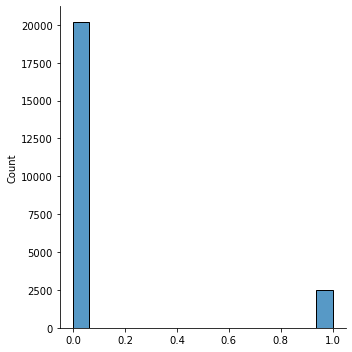

In [6]:
sns.displot(y_detect_train)
print('Ratio of seizure samples in the training data = {}'
      .format(round(y_detect_train.sum()/ len(y_detect_train), 4)))

Similarly, we observe class imbalance with respect to the different types of seizures. This distribution of the labels on the training data indicates that there are three labels that dominate the data - 'CPSZ', 'FNSZ' and 'GNSZ'. As a result one may expect that the algorithms will be able to better learn and generalize these labels since there are more samples to learn from. As discussed before, one can weight the samples from classes with less observations heavier to aid the algorithm in better classifying them. Since the seizure type TNSZ has very few observations in the original dataset (and no observations in our preprocessed data) we drop it from the labels. 

In [7]:
label_names.pop()

'TNSZ'

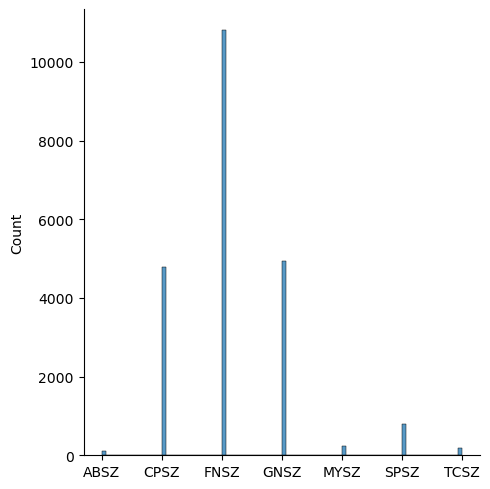

In [8]:
# Label distributions
plt.rcParams['figure.dpi'] = 100
ax = sns.displot(y_classify_train)
plt.xticks(range(len(label_names)), labels=label_names);

An important aspect of modeling EEG, and more generally data, is understanding some of the characteristics of the features and their implications to building and explaining predictive models. To study the relationships between the features themselves, as well as the target, one can use correlation plots. Below we use a sample of the training data in order to calculate the correlations between features samples from each of the different 20 channels. 

<AxesSubplot:>

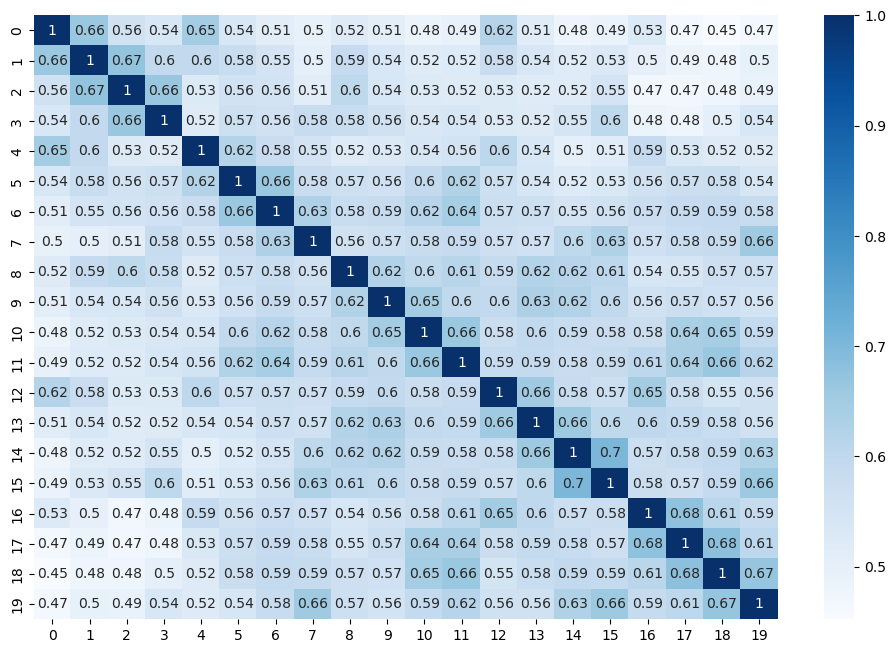

In [9]:
# Sample columns and rows to use in constructing the feature correlation matrix
cols = np.linspace(1,X_detect_train.shape[1]-1, 20).astype(int)
rows = np.linspace(1,X_detect_train.shape[0]-1, 10000).astype(int)

# Calculate the feature correlation matrix
rho = np.corrcoef(X_detect_train[np.ix_(rows, cols)].T)

# Plot the feature correlation matrix
plt.figure(figsize=(12,8))
sns.heatmap(rho, cmap='Blues', annot=True)

The feature correlation matrix reveals two interesting patterns. First it seems that the channels that are close to each other in number have higher correlation than the channels that are further appart in number. This is seen in the heatmap as we see higher correlation values concentrated near the diagonal with relatively lower values in the corners. The second important observation here is that while some of the channels exhibit moderate correlation levels, none of the channels have high degrees of correlation. While, high correlation is not necessarily detrimental for prediction, it makes it harder to explain the impact of the individual features on the predictions as it is not clear how to distribute the attribution for features that are highly correlated. 

#### Logistic Regression

We begin by initializing the LogisticRegression classifier. We test two different penalties as discussed in equation (4). The logisitc regression classifier is initialized, by choosing the penalty, the solver used for optimizing the loss function and the number of iterations used in the optimization. Additionaly, we allow for an intercept term. The sklearn implementation of the logistic regression classifier adds a column of 1s to the dataset to which the intercept term is fitted. By specifying the class_weight to equal 'balanced' we are assigning weights to each class inversely proportionaly to the frequency of that class in the training data.

In [11]:
log_reg_szr_detect = LogisticRegression(penalty='l1', fit_intercept=True, solver='liblinear', max_iter=1000, class_weight='balanced', verbose=3, random_state=42)

Once the logistic regression classifier is initialized we apply the fit method to the training data in order to fit the model and obtain the coefficients for each feature - $\theta$ 

In [12]:
log_reg_szr_detect_fit = log_reg_szr_detect.fit(X_detect_train, y_detect_train)

[LibLinear]

The estimated coefficients for each feature are stored in the coef_ attribute. When using L1 penalty the algorithm can set coefficients to 0 that it deems unimportant for prediction. If there are many highly correlated predictor features, the algorithm randomly selects which one is set to 0, which can lead to inferential issues.

The large amount of coefficients displayed below highlights the general tradeoff between explainability of models and ability to accurately predict. While adding more features can potentially lead to a better fit, adding too many features makes ones ability to study the coefficients and determine their impact on the outcome more difficult. 

In [13]:
log_reg_szr_detect_fit.coef_

array([[ 0.01806056, -0.18178112, -0.02016096, -0.09954873,  0.01616064,
         0.03703718, -0.04402776,  0.0367867 ,  0.22678892,  0.05985733,
        -0.17006887,  0.0482903 ,  0.        ,  0.03386599,  0.01190647,
        -0.10823753, -0.139146  ,  0.0413212 ,  0.0582321 , -0.1451039 ,
         0.08458559, -0.01790759,  0.18364528,  0.08317355,  0.03702547,
        -0.03225317, -0.07575358,  0.03220616,  0.01656186,  0.09340748,
        -0.04967468,  0.20052931,  0.00816253, -0.00211843,  0.0877986 ,
         0.03433253, -0.01778452, -0.21384316, -0.20480777, -0.10457366,
         0.0448931 , -0.03608094, -0.16447105, -0.1123502 , -0.18800734,
        -0.16780165, -0.07785864, -0.08280509, -0.18517482,  0.05703127,
         0.24344295, -0.00377581, -0.21348713, -0.1089266 , -0.08129482,
        -0.1103145 , -0.15712703, -0.08262177, -0.06216583, -0.11310881,
        -0.04592356, -0.12006294,  0.09496362, -0.18749415, -0.00961065,
         0.12429032, -0.06603328,  0.0761228 ,  0.1

In certain instances it is beneficial to center and scale the data before fitting logistic regression. This ensures that all inputs are on the same scale. This is especially useful when penalized logistic regression is used. In particular if the magnitued of the features in X is very different than applying the same $\lambda$ to the coefficients of the different features can have disproportionate effects. In particular, the feature that has lower range of possible values will be penalized  more than another feature that naturally has higher range of possible values. To check the magnitude of the different features we look at the features with max and min ranges.

In [14]:
largest_val_idx = np.argmax(np.max(X_detect_train, axis = 0))
smallest_val_idx = np.argmin(np.min(X_detect_train, axis = 0))

# Get the range of the smallest and largest values in the feature vector
print(np.max(X_detect_train[:,largest_val_idx], axis = 0), np.min(X_detect_train[:,largest_val_idx], axis = 0))
print(np.max(X_detect_train[:,smallest_val_idx], axis = 0), np.min(X_detect_train[:,smallest_val_idx], axis = 0))


5.882349877198722 -12.450474246364099
5.4854041808161025 -13.954956235423953


Based on the ranges above it does not seem like the magnitude of the values among the features is very variable and hence normalizing the data is not as necessary. However, to illustrate how prediction with penalized logistic regression is performed we go ahead and normalize the data anyway. First one needs to fit the scaler to the training data in order to learn the scaler parameters. In this case we subtract the mean and divide by the standard deviation of each feature in X_train. The scaler object then saves the mean and standard deviation, which is later used to normalize the validation data.

In [15]:
# Detection: apply the standard scaler to the training, validation and test data. 
scaler = StandardScaler().fit(X_detect_train)
X_detect_train = scaler.transform(X_detect_train)
X_detect_val = scaler.transform(X_detect_val)
X_detect_test = scaler.transform(X_detect_test)

# Classification: apply the standard scaler to the training, validation and test data. 
scaler = StandardScaler().fit(X_classify_train)
X_classify_train = scaler.transform(X_classify_train)
X_classify_val = scaler.transform(X_classify_val)
X_classify_test = scaler.transform(X_classify_test)

In [16]:
# Fit the logistic regression model to the normalized data
log_reg_szr_detect_fit = log_reg_szr_detect.fit(X_detect_train, y_detect_train)

[LibLinear]

Once the model is fit to the training data interest lies in determining how well the model generalizes to unseen data. This provides information on how one would expect the model to perform on future patients. To assess the generalization ability of the model we use the fitted model to predict the labels on a validation set, which was left out from our original dataset and was not used when fitting the model. 

It is important to note that the assumption that one relies on when using a validation set to determine the ability of the model to generalize to future unseen data is that the distributions of the training and validation data are both representative of the future distribution of the data. If we exepct the data to change in the future than the performance of the model can deteriorate and will diverge from the results obtained on the validation data.  

In [17]:
# Check the distribution of the labels 
print('Ratio of seizure samples in the validation data = {}'
      .format(round(y_detect_val.sum()/ len(y_detect_val), 4)))

Ratio of seizure samples in the validation data = 0.1135


Once we check that the distribution of the labels in the validation data is similar to the one in the training data we can proceed by predicting the labels for the validation data. It is important to note that usually, one must also compare to make sure that the distribution of the features is the same between the training and validation data sets. 

It is important that the distribution of the data used for training the algorithm matches that of the validation data. Therefore we need to apply the standard scaler learned on the training data to the validation data. This is done in cases where at inference time, one does not have access to a large sample of the new data and hence can not accurately calculate the mean and standard deviation of each feature needed in order to scale the data. While the validation data in this case is large enough, this is not always the case at inference time and hence the standard practice is to use the mean and standard deviation of the training data to center and scale the validation data.

In [18]:
# Predict the labels on the validation data
yhat_detect_val = log_reg_szr_detect_fit.predict(X_detect_val)

# Calculate several performance metrics
metrics_dict = {'f1': f1_score(y_detect_val, yhat_detect_val), 
                'roc_auc': roc_auc_score(y_detect_val, yhat_detect_val),
                'precision': precision_score(y_detect_val, yhat_detect_val),
                'recall': recall_score(y_detect_val, yhat_detect_val),
                'prc_auc': average_precision_score(y_detect_val, yhat_detect_val)}
print(metrics_dict)

{'f1': 0.4650907091808686, 'roc_auc': 0.7848672776457278, 'precision': 0.3341232227488152, 'recall': 0.7649186256781193, 'prc_auc': 0.2822601633800824}


The f1 score, prc_auc and precision scores indicate that the logistic regression with $l1$ penalty may not be able to fit the data well. In particular, the model struggles to predict the seizure segments. The recall and roc_auc score are a bit higher, which attests to the models ability to predict the majority class(non-seizures) better than the minority class (seizures). 

Logistic regression can also be extended to the multiclass case. To do so one need to change the objective function. In *scikit-learn* we can do that by specifying the *multi_class* parameter. There are two options currently available *multi_class='ovr'* which performs one-vs-rest and *multi_class='multinomial'* which uses the cross-entropy loss. For more details as well as supported optimization routines for multiclass classification we refer the reader to the package's documentation

In [19]:
# Initialize the multinomial regression object
log_reg_szr_classify = LogisticRegression(penalty='l1', fit_intercept=True, multi_class='multinomial', 
                                          solver='saga', max_iter=500, class_weight='balanced', verbose=3, 
                                          random_state=42)

# Fit the logistic regression model to the normalized data
log_reg_szr_classify_fit = log_reg_szr_classify.fit(X_classify_train, y_classify_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 414 seconds


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.9min finished


The fitted logistic regression model used $l1$ penalty along with the default value for the penalty parameter $\lambda$. Typically, model parameters are learned through cross-validation and more than one parameter is tested. The $\lambda$ value that results in the highest value for a chosen metric (such as f-1 score, auc etc.) on the validation set is used for the final model to make predictions.  

In [20]:
pen_param = np.logspace(-3, 1.5, 15)
pen_type = ['l1', 'l2']
df_cols = ['penalty', 'param', 'f1_score']
f1_detect_df = pd.DataFrame(columns=df_cols)
f1_classify_df = pd.DataFrame(columns=df_cols)
for pen in pen_type:
    for c in pen_param:
        print('Current penalty parameter is = {}'.format(pen))
        print('Current penalty value is = {}'.format(c))
        
        # Seizure Detection
        lr_detect = LogisticRegression(C=c, penalty=pen, fit_intercept=True, solver='saga', max_iter=500, class_weight='balanced', 
                                verbose=0, random_state=42, n_jobs=-1)
        lr_detect_fit = lr_detect.fit(X_detect_train, y_detect_train)
        y_detect_pred = lr_detect_fit.predict(X_detect_val)
        f1_detect = f1_score(y_detect_val, y_detect_pred)
        f1_detect_df = pd.concat([f1_detect_df, pd.DataFrame([[pen, np.log10(c), f1_detect]], columns=df_cols)])
        
        # Seizue Classification
        lr_classify = LogisticRegression(C=c, penalty=pen, fit_intercept=True, multi_class='multinomial', 
                                solver='saga', max_iter=500, class_weight='balanced', 
                                verbose=0, random_state=42, n_jobs=-1) 
        lr_classify_fit = lr_classify.fit(X_classify_train, y_classify_train)
        y_classify_pred = lr_classify_fit.predict(X_classify_val)
        f1_classify = f1_score(y_classify_val, y_classify_pred, average='macro')
        f1_classify_df = pd.concat([f1_classify_df, pd.DataFrame([[pen, np.log10(c), f1_classify]], columns=df_cols)])
        
f1_detect_df.reset_index(inplace=True)
f1_classify_df.reset_index(inplace=True)
    

Current penalty parameter is = l1
Current penalty value is = 0.001


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l1
Current penalty value is = 0.002096179992453128


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l1
Current penalty value is = 0.004393970560760791


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l1
Current penalty value is = 0.00921055317689482


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l1
Current penalty value is = 0.019306977288832506


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l1
Current penalty value is = 0.040470899507597614


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l1
Current penalty value is = 0.08483428982440726


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l1
Current penalty value is = 0.1778279410038923


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l1
Current penalty value is = 0.3727593720314942


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l1
Current penalty value is = 0.7813707376518101


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l1
Current penalty value is = 1.6378937069540647


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l1
Current penalty value is = 3.433320018281997


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l1
Current penalty value is = 7.196856730011529


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l1
Current penalty value is = 15.085907086001793


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l1
Current penalty value is = 31.622776601683793


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l2
Current penalty value is = 0.001


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l2
Current penalty value is = 0.002096179992453128


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l2
Current penalty value is = 0.004393970560760791


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l2
Current penalty value is = 0.00921055317689482


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l2
Current penalty value is = 0.019306977288832506


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l2
Current penalty value is = 0.040470899507597614


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l2
Current penalty value is = 0.08483428982440726


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l2
Current penalty value is = 0.1778279410038923


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l2
Current penalty value is = 0.3727593720314942


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l2
Current penalty value is = 0.7813707376518101


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l2
Current penalty value is = 1.6378937069540647


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l2
Current penalty value is = 3.433320018281997


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l2
Current penalty value is = 7.196856730011529


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l2
Current penalty value is = 15.085907086001793


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Current penalty parameter is = l2
Current penalty value is = 31.622776601683793


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [21]:
f1_detect_df.to_pickle(path='{}figures/f1_df_detect.pkl'.format(path_detect))
f1_classify_df.to_pickle(path='{}figures/f1_df_classify.pkl'.format(path_classify))


In [22]:
with open('{}figures/f1_df_detect.pkl'.format(path_detect), "rb") as fp:
    f1_detect_df = pickle.load(fp)

with open('{}figures/f1_df_classify.pkl'.format(path_classify), "rb") as fp:
    f1_classify_df = pickle.load(fp)



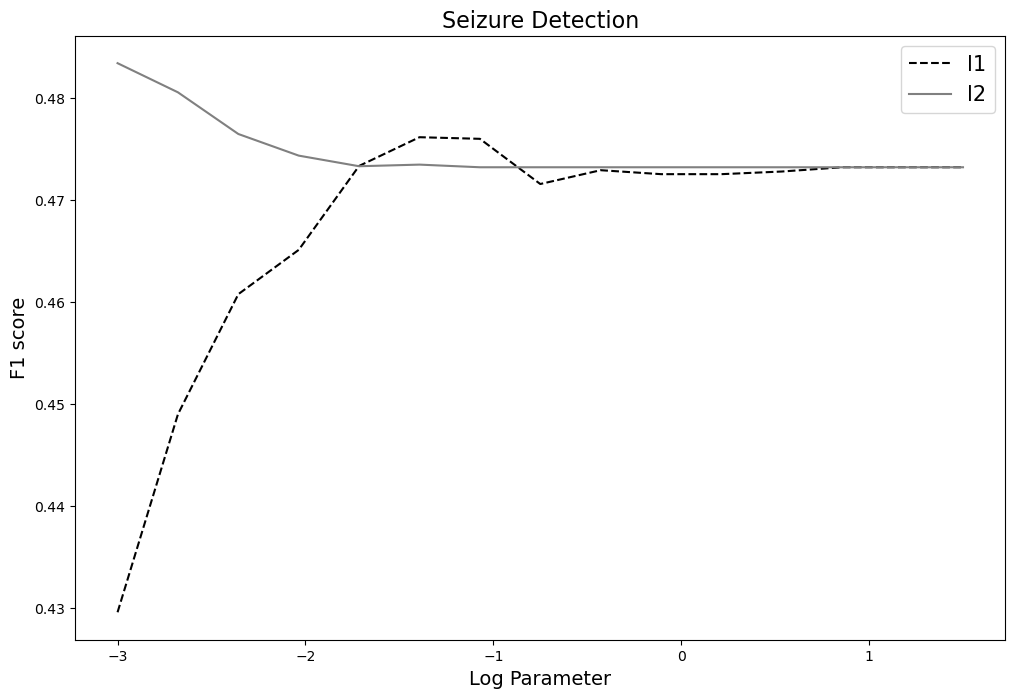

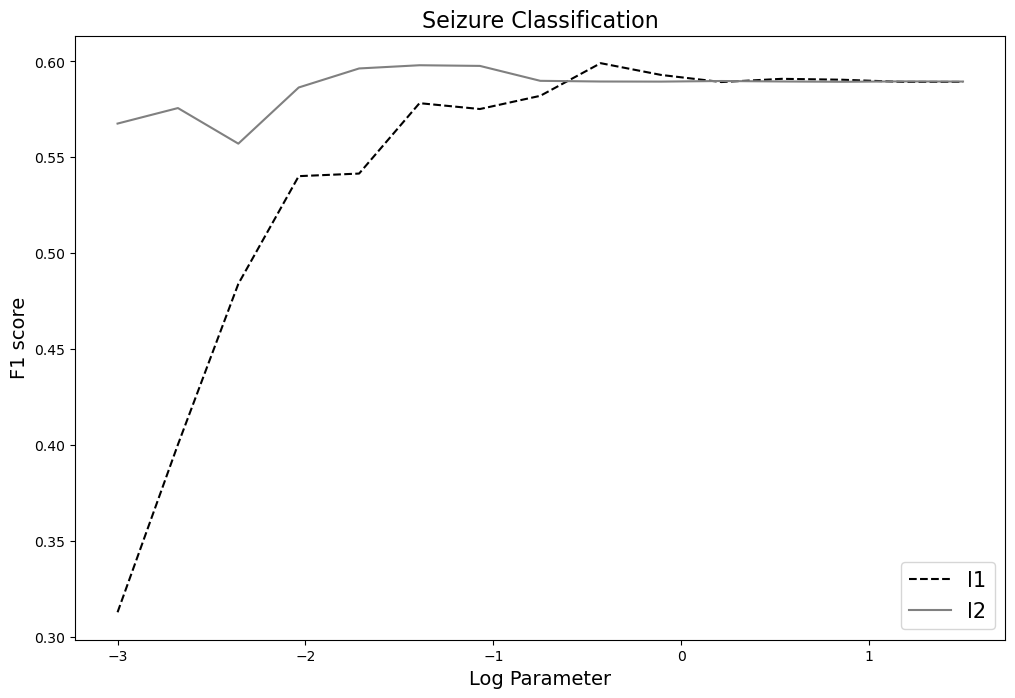

In [23]:
plt.figure(figsize=(12,8))
ax = sns.lineplot(data=f1_detect_df.reset_index(), x='param', y='f1_score', hue='penalty', palette=['black', 'gray'])
ax.lines[0].set_linestyle("--")
plt.title('Seizure Detection', fontsize=16)
plt.ylabel('F1 score', fontsize=14)
plt.xlabel('Log Parameter', fontsize=14)
leg = plt.legend(fontsize=15)
leg_lines = leg.get_lines()
leg_lines[0].set_linestyle("dashed")

plt.figure(figsize=(12,8))
ax = sns.lineplot(data=f1_classify_df.reset_index(), x='param', y='f1_score', hue='penalty',  palette=['black', 'gray'])
ax.lines[0].set_linestyle("--")
plt.title('Seizure Classification', fontsize=16)
plt.ylabel('F1 score', fontsize=14)
plt.xlabel('Log Parameter', fontsize=14)
plt.legend(fontsize=15)
leg = plt.legend(fontsize=15)
leg_lines = leg.get_lines()
leg_lines[0].set_linestyle("dashed")

In the figures above we plot the f1 score on the held out validation data for different values of the penalty parameters for $l1$ (blue) and $l2$ (orange) for the detection and classification tasks. The values on the x-axis are on log10 scale. Smaller values indicate stronger regularization of the model parameters. Small values for $l1$ result in heavy regularization and low f1 values on both tasks. As the regularization strength reduces the model is able to learn better and the validation f1 score increases. For seizure detection, $l2$ achieves the best f1 score at the strongest level of regularization. In the seizure classification case, the $l2$ penalty seem to produce more stable results even when the regularization is strong.

Overall, based on the graphs, one can conclude that the best performing penalized logistic regression is when one selects an $l2$ penalty and sets the regularizaion parameter to $10^{-3}$ for sezire detection. The highest f1 score for seizure classification is achieved when the $l2$ penalty is selected and the parameter is set to $10^{-1}$.

#### K-Nearest Neightbours

Next we study the performance of K-Nearest Neighbors on the tasks of seizure detection and classification. KNN uses a distance based metric in order to make predictions. Therefore, it is another algorithm that works better if the data is normalized. If the data is not normalize features that have higher values will have higher influence on calculating the distance to the closest neighbor even if they are not the most similar overall. In order to prevent large features to unfairly skew the distance values, normalization is suggested. 

In [ ]:
n_neighbors = np.linspace(1, 50, 5).astype('int')
weights = ['uniform', 'distance']
df_cols = ['weights', 'n_neighbors', 'f1_score']
f1_df_knn_detect = pd.DataFrame(columns=df_cols)
f1_df_knn_classify = pd.DataFrame(columns=df_cols)
for w in weights:
    for k in n_neighbors:
        print('Current weight parameter is = {}'.format(w))
        print('Current #neighbors value is = {}'.format(k))
        
        # Detection
        knn_detect = KNeighborsClassifier(n_neighbors=k, weights=w, algorithm='auto', p=2, n_jobs=-1)
        knn_detect_fit = knn_detect.fit(X_detect_train, y_detect_train)
        y_detect_pred = knn_detect_fit.predict(X_detect_val)
        f1 = f1_score(y_detect_val, y_detect_pred)
        f1_df_knn_detect = pd.concat([f1_df_knn_detect, pd.DataFrame([[w, k, f1]], columns=df_cols)])
        
        # Classification
        knn_classify = KNeighborsClassifier(n_neighbors=k, weights=w, algorithm='auto', p=2, n_jobs=-1)
        knn_classify_fit = knn_classify.fit(X_classify_train, y_classify_train)
        y_classify_pred = knn_classify_fit.predict(X_classify_val)
        f1 = f1_score(y_classify_val, y_classify_pred, average='macro')
        f1_df_knn_classify = pd.concat([f1_df_knn_classify, pd.DataFrame([[w, k, f1]], columns=df_cols)])

f1_df_knn_detect.reset_index(inplace=True)
f1_df_knn_classify.reset_index(inplace=True)

Current weight parameter is = uniform
Current #neighbors value is = 1
Current weight parameter is = uniform
Current #neighbors value is = 13
Current weight parameter is = uniform
Current #neighbors value is = 25
Current weight parameter is = uniform
Current #neighbors value is = 37
Current weight parameter is = uniform
Current #neighbors value is = 50
Current weight parameter is = distance
Current #neighbors value is = 1
Current weight parameter is = distance
Current #neighbors value is = 13


In [ ]:
f1_df_knn_detect.to_pickle(path='{}figures/f1_df_knn_detect.pkl'.format(path_detect))
f1_df_knn_classify.to_pickle(path='{}figures/f1_df_knn_classify.pkl'.format(path_classify))

In [ ]:
with open('{}figures/f1_df_knn_detect.pkl'.format(path_detect), "rb") as fp:
    f1_df_knn_detect = pickle.load(fp)

with open('{}figures/f1_df_knn_classify.pkl'.format(path_classify), "rb") as fp:
    f1_df_knn_classify = pickle.load(fp)



In [ ]:
plt.figure(figsize=(10,8))
ax = sns.lineplot(data=f1_df_knn_detect, x='n_neighbors', y='f1_score', hue='weights', palette=['black', 'gray'])
ax.lines[0].set_linestyle("--")
plt.title('Seizure Detection', fontsize=16)
plt.ylabel('F1 score', fontsize=14)
plt.xlabel('# Neighbors', fontsize=14)
leg = plt.legend(fontsize=15)
leg_lines = leg.get_lines()
leg_lines[0].set_linestyle("dashed")

plt.figure(figsize=(10,8))
ax = sns.lineplot(data=f1_df_knn_classify, x='n_neighbors', y='f1_score', hue='weights', palette=['black', 'gray'])
ax.lines[0].set_linestyle("--")
plt.title('Seizure Classification', fontsize=16)
plt.ylabel('F1 score', fontsize=14)
plt.xlabel('# Neighbors', fontsize=14)
leg = plt.legend(fontsize=15)
leg_lines = leg.get_lines()
leg_lines[0].set_linestyle("dashed")

As the number of neighbors increases the f1_score drops significantly. In the plot weights corresponds to the weight the way in which each neighbor is treated. Uniform represents treating each neighbor in the calculation of the predictions equally. Distance represents assigning weights to each neighbor inversely proportional to the distance of the neighbor from the prediction point. The distance does not seem to have an effect on the performance of the algorithm until about 37 neighbors. At that point we see that the 'distance' weights perform better. In this particular case it seems that using only the closest neighbor for prediction performs best. Despite the performance shown here, generally using a single neighbor can lead to more variance in the predictions. Adding more neighbors adds a smoothing effect and can potentially safeguard from outliers or slight changes in the distribution better. Therefore, care is advised when selecting only a signle neighbor when applying KNN. 

In [ ]:
ntrees = np.linspace(100, 2000, 15).astype('int')
nfeatures = X_classify_train.shape[1]
features = [nfeatures, int(np.sqrt(nfeatures)), int(nfeatures**(1/3))] 
df_cols = ['features', 'trees', 'f1_score']
f1_df_rf_detect = pd.DataFrame(columns=df_cols)
f1_df_rf_classify = pd.DataFrame(columns=df_cols)
for tree in ntrees:
    for f in features:
        print('Current feature parameter is = {}'.format(f))
        print('Current #trees value is = {}'.format(tree))
        
        # Detection
        rf_detect = RandomForestClassifier(n_estimators=tree, max_features=f,
                                           random_state=42, class_weight='balanced', 
                                           verbose=0, n_jobs=-1)
        rf_fit_detect = rf_detect.fit(X_detect_train, y_detect_train)
        y_detect_pred = rf_fit_detect.predict(X_detect_val)
        f1 = f1_score(y_detect_val, y_detect_pred)
        f1_df_rf_detect = pd.concat([f1_df_rf_detect, pd.DataFrame([[f, tree, f1]], columns=df_cols)])
        
        # Classification
        rf_classify = RandomForestClassifier(n_estimators=tree, max_features=f,
                                    random_state=42, class_weight='balanced', 
                                    verbose=0, n_jobs=-1)
        rf_fit_classify = rf_classify.fit(X_classify_train, y_classify_train)
        y_classify_pred = rf_fit_classify.predict(X_classify_val)
        f1 = f1_score(y_classify_val, y_classify_pred, average='macro')
        f1_df_rf_classify = pd.concat([f1_df_rf_classify, pd.DataFrame([[f, tree, f1]], columns=df_cols)])

f1_df_rf_classify.reset_index(inplace=True)
f1_df_rf_detect.reset_index(inplace=True)

In [ ]:
f1_df_rf_detect.to_pickle(path='{}figures/f1_df_rf_detect.pkl'.format(path_detect))
f1_df_rf_classify.to_pickle(path='{}figures/f1_df_rf_classify.pkl'.format(path_classify))

In [ ]:
with open('{}figures/f1_df_rf_detect.pkl'.format(path_detect), "rb") as fp:
    f1_df_rf_detect = pickle.load(fp)

with open('{}figures/f1_df_rf_classify.pkl'.format(path_classify), "rb") as fp:
    f1_df_rf_classify = pickle.load(fp)



In [ ]:
plt.figure(figsize=(10,8))
ax = sns.lineplot(data=f1_df_rf_detect, x='trees', y='f1_score', hue='features', palette=['black', 'gray', 'brown'])
ax.lines[0].set_linestyle("--")
ax.lines[2].set_linestyle("dotted")
plt.title('Seizure Detection', fontsize=16)
plt.ylabel('F1 score', fontsize=14)
plt.xlabel('# Trees', fontsize=14)
plt.rcParams['legend.title_fontsize'] = 'xx-large'
leg = plt.legend(fontsize=15, title='# Features')
leg_lines = leg.get_lines()
leg_lines[0].set_linestyle("dashed")
leg_lines[2].set_linestyle("dotted")

plt.figure(figsize=(10,8))
ax = sns.lineplot(data=f1_df_rf_classify, x='trees', y='f1_score', hue='features', palette=['black', 'gray', 'brown'])
ax.lines[0].set_linestyle("--")
ax.lines[2].set_linestyle("dotted")
plt.title('Seizure Classification', fontsize=16)
plt.ylim((0.565, 0.68))
plt.ylabel('F1 score', fontsize=14)
plt.xlabel('# Trees', fontsize=14)
leg = plt.legend(fontsize=15, loc='lower right', title='# Features')
leg_lines = leg.get_lines()
leg_lines[0].set_linestyle("dashed")
leg_lines[2].set_linestyle("dotted")

While the random forest algorithm has several parameters that need to be learned from the data, here we explore the impact of two of them the number of features used in creating each tree and the number of trees. Overall the random forest algorithm does not seem to perform well on the seizure detection task as seen in the low f1 scores in the figure above. Generally, in this case it looks like increasing the number of trees does not improve the performance of the algoritm after about 250 trees. One can see improvement in the f1 scores as more features are used to build each tree. 

In [ ]:
# Create class weights
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_classify_train #provide your own target name
)
lrs=[0.001, 0.01, 0.1]
nboost = np.linspace(50, 2000, 10).astype(int)
scale_pos_weight = (len(y_detect_train) - sum(y_detect_train))/ sum(y_detect_train)
df_cols = ['lr', 'trees', 'f1_score']
f1_df_xgb_detect = pd.DataFrame(columns=df_cols)
f1_df_xgb_classify = pd.DataFrame(columns=df_cols)
for boost in nboost:
    for lr in lrs:
        print('Current learning rate is = {}'.format(lr))
        print('Current #boosters value is = {}'.format(boost))
        
        # Detect
        xgb_detect = xgb.XGBClassifier(n_estimators=boost,
                                       learning_rate=lr,
                                       objective = 'binary:logistic', 
                                       random_state=42, scale_pos_weight=scale_pos_weight,
                                       n_jobs=-1)
        xgb_fit_detect = xgb_detect.fit(X_detect_train, y_detect_train)
        y_detect_pred = xgb_fit_detect.predict(X_detect_val)
        f1 = f1_score(y_detect_val, y_detect_pred)
        f1_df_xgb_detect = pd.concat([f1_df_xgb_detect, pd.DataFrame([[lr, boost, f1]], columns=df_cols)])
        
        
        # Classify
        xgb_classify = xgb.XGBClassifier(n_estimators=boost,
                                         learning_rate=lr,
                                         objective = 'multi:softmax', 
                                         random_state=42,
                                         n_jobs=-1)
        xgb_fit_classify = xgb_classify.fit(X_classify_train, y_classify_train, sample_weight=sample_weights)
        y_classify_pred = xgb_fit_classify.predict(X_classify_val)
        f1 = f1_score(y_classify_val, y_classify_pred, average='macro')
        f1_df_xgb_classify = pd.concat([f1_df_xgb_classify, pd.DataFrame([[lr, boost, f1]], columns=df_cols)])

        
f1_df_xgb_detect.reset_index(inplace=True)
f1_df_xgb_classify.reset_index(inplace=True)

In [ ]:
f1_df_xgb_detect.to_pickle(path='{}figures/f1_df_xgb_detect.pkl'.format(path_detect))
f1_df_xgb_classify.to_pickle(path='{}figures/f1_df_xgb_classify.pkl'.format(path_classify))

In [ ]:
with open('{}figures/f1_df_xgb_detect.pkl'.format(path_detect), "rb") as fp:
    f1_df_xgb_detect = pickle.load(fp)

with open('{}figures/f1_df_xgb_classify.pkl'.format(path_classify), "rb") as fp:
    f1_df_xgb_classify = pickle.load(fp)



In [ ]:
plt.figure(figsize=(10,8))
ax = sns.lineplot(data=f1_df_xgb_detect, x='trees', y='f1_score', hue='lr', palette=['black', 'gray', 'brown'])
ax.lines[0].set_linestyle("--")
ax.lines[2].set_linestyle("dotted")
plt.title('Seizure Detection', fontsize=16)
plt.ylabel('F1 score', fontsize=14)
plt.xlabel('# Estimators', fontsize=14)
leg = plt.legend(fontsize=15, loc='upper left', title='Learning Rate')
leg_lines = leg.get_lines()
leg_lines[0].set_linestyle("dashed")
leg_lines[2].set_linestyle("dotted")

plt.figure(figsize=(10,8))
ax = sns.lineplot(data=f1_df_xgb_classify, x='trees', y='f1_score', hue='lr', palette=['black', 'gray', 'brown'])
ax.lines[0].set_linestyle("--")
ax.lines[2].set_linestyle("dotted")
plt.title('Seizure Classification', fontsize=16)
plt.ylabel('F1 score', fontsize=14)
plt.xlabel('# Estimators', fontsize=14)
leg = plt.legend(fontsize=15, title='Learning Rate')
leg_lines = leg.get_lines()
leg_lines[0].set_linestyle("dashed")
leg_lines[2].set_linestyle("dotted")

Similarly to Random Forests, XGBoost also has several parameters that can generally be tuned. In the figure above we focus only on two of them the number of boosting rounds (trees in our case) and the learning rate used to determine the attribution of each successive model to the overall prediction. One can notice a generally increasing trend in the f1 score with respect to the boosting round used. However, the marginal increase of adding more boosting rounds decreases as more trees are added. The sensitivity of the performance of the XGBoost algorithm with respect to the learning rate is very noticeable. The XGBoost alogrithm overall performs very well on the dataset. The best performance seems to be F1 score of about 0.73 with learning rate of 0.1 and number of trees being 1750. 

While certain models, such as penalized logistic regression and KNN contain only a couple of parameters and one can use 2D graphs to study the impact of the parameter choice on the ability of the model to generalize, others may have many parameters and such 2D graphs will not be easy to create and utilize for finding the optimal parameter values. Random Forest and XGBoost are examples of such algorithms and they can benefit from cross-validation with all parameters. 

#### Hyperparameter optimization seizure detection

In [ ]:
param_grid = {'n_estimators': np.linspace(50, 2000, 20).astype(int),
                'learning_rate': [0.1],
                'gamma': np.linspace(0., 5., 10), # range(0,infty)
                'max_depth': np.linspace(3, 30).astype(int), # range(0, infty)
                'min_child_weight': np.linspace(3., 50., 10).astype(int), # range(0, infty)
                'subsample': np.linspace(0.51, 1, 10), # range (0, 1]
                'colsample_bytree': np.linspace(0.7, 1, 5),
                'reg_lambda': np.logspace(-2, 2, 15),
                'reg_alpha': np.logspace(-2, 2, 15)
                }
xgb_estimator = xgb.XGBClassifier(objective = 'binary:logistic', 
                                  random_state=42, scale_pos_weight=scale_pos_weight,
                                  n_jobs=-1)

split_index = [-1] * X_detect_train.shape[0] + [0] * X_detect_val.shape[0]
cross_validation_type = PredefinedSplit(test_fold=split_index)
xgb_rs = RandomizedSearchCV(estimator=xgb_estimator, param_distributions=param_grid, cv=cross_validation_type, 
                                                scoring='f1', n_iter=20, refit=True)
X = np.concatenate((X_detect_train, X_detect_val))
y = np.concatenate((y_detect_train, y_detect_val))

xgb_cv_fit = xgb_rs.fit(X,y)

with open('xgb_seizure_detection_cv.pkl', 'wb') as file:
        pickle.dump(xgb_cv_fit, file)

In [ ]:
xgb_cv_fit.cv_results_

In [ ]:
with open('xgb_seizure_detection_cv.pkl', 'rb') as file:
        xgb_cv_fit_detect = pickle.load(file)

In [ ]:
print('The best f1-score is = {}'.format(round(max(xgb_cv_fit_detect.cv_results_['mean_test_score']),4)))

Performing a cross-validation over the parameter space, using random search have improved the f1 score. A potential further improvement can be achieved by performing a grid search near the optimal parameters found via the random search. 

In [ ]:
# Predict on the test data
y_pred = xgb_cv_fit_detect.predict(X_detect_test)
f1 = f1_score(y_detect_test, y_pred)
print('f1-score = {}'.format(f1))

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_detect_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(12,8))
cm_plt = sns.heatmap(cm, cmap='Blues', annot=True, fmt='g', xticklabels=['non-seizure', 'seizure'], 
                     yticklabels=['non-seizure', 'seizure'], annot_kws={'size': 15})
cm_plt.set_xticklabels(cm_plt.get_xmajorticklabels(), fontsize = 18)
cm_plt.set_yticklabels(cm_plt.get_ymajorticklabels(), fontsize = 18)

#### Hyperparameter optimization seizure classification

In [ ]:
# Create class weights
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_classify_train #provide your own target name
)

In [ ]:
param_grid = {'n_estimators': np.linspace(50, 2000, 20).astype(int),
                'learning_rate': [0.1],
                'gamma': np.linspace(0., 5., 10), # range(0,infty)
                'max_depth': np.linspace(3, 30).astype(int), # range(0, infty)
                'min_child_weight': np.linspace(3., 50., 10).astype(int), # range(0, infty)
                'subsample': np.linspace(0.51, 1, 10), # range (0, 1]
                'colsample_bytree': np.linspace(0.7, 1, 5),
                'reg_lambda': np.logspace(-2, 2, 15),
                'reg_alpha': np.logspace(-2, 2, 15)
                }
xgb_estimator = xgb.XGBClassifier(objective = 'multi:softmax', 
                                  random_state=42,
                                  n_jobs=-1,
                                  verbose=1)

split_index = [-1] * X_classify_train.shape[0] + [0] * X_classify_val.shape[0]
cross_validation_type = PredefinedSplit(test_fold = split_index)
xgb_rs = RandomizedSearchCV(estimator=xgb_estimator, param_distributions=param_grid, cv=cross_validation_type, 
                                                scoring='f1_macro', n_iter=20, refit=False)
X = np.concatenate((X_classify_train, X_classify_val))
y = np.concatenate((y_classify_train, y_classify_val))

xgb_cv_fit = xgb_rs.fit(X, y, sample_weight=sample_weights)

with open('xgb_seizure_classification_cv_20220710.pkl', 'wb') as file:
        pickle.dump(xgb_cv_fit, file)

In [ ]:
with open('xgb_seizure_classification_cv_20220622.pkl', 'rb') as file:
        xgb_cv_classify = pickle.load(file)

In [ ]:
xgb_ = xgb.XGBClassifier(**xgb_cv_fit.best_params_, 
                         objective = 'multi:softmax', 
                         random_state=42,
                         n_jobs=8)
xgb_fitted_rs = xgb_.fit(X_classify_train, y_classify_train, sample_weight=sample_weights)

In [ ]:
y_pred = xgb_fitted_rs.predict(X_classify_train)
f1 = f1_score(y_classify_train, y_pred, average='macro')
print('f1_score_train = {}'.format(f1))

In [ ]:
y_pred = xgb_fitted_rs.predict(X_classify_val)
f1 = f1_score(y_classify_val, y_pred, average='macro')
print('f1_score_val = {}'.format(f1))

In [ ]:
y_pred = xgb_fitted_rs.predict(X_classify_test)
f1 = f1_score(y_classify_test, y_pred, average='macro')
print('f1_score_val = {}'.format(f1))

In [ ]:
print(classification_report(y_classify_test, y_pred))

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_classify_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(12,8))
cm_plt = sns.heatmap(cm, cmap='Blues', annot=True, fmt='g', xticklabels=label_names, 
                     yticklabels=label_names, annot_kws={'size': 14})
cm_plt.set_xticklabels(cm_plt.get_xmajorticklabels(), fontsize = 15)
cm_plt.set_yticklabels(cm_plt.get_ymajorticklabels(), fontsize = 15)